In [84]:
import math  
import numpy as np   
import random  as rd
import matplotlib.pyplot as plt  
from matplotlib import colors
import numba  
from numba import njit  
import time  
from matplotlib.pyplot import figure
import random as rd

In [85]:
from scipy.sparse import csr_matrix
from scipy import linalg

In [86]:
# from scipy import misc

# np.random.seed(0)
# plt.close('all')

# # Load image
# X = misc.ascent()
# X = X/np.max(X)
# ny, nx = X.shape
# plt.imshow(X,cmap="gray")

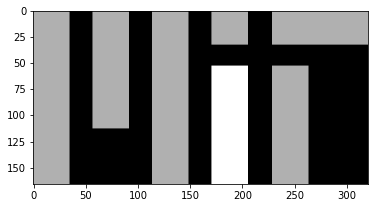

In [87]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread("logoMIT.png",0)

#Displaying image using plt.imshow() method
plt.imshow(img,cmap="gray")

In [88]:
img.shape

(166, 321)

In [89]:
rank = np.linalg.matrix_rank(img)
rank

4

In [90]:
M = img
# M = M/np.max(M)
n1,n2 = M.shape
ratio = 0.2
p = round(n1*n2*ratio)

In [91]:
# n1=200
# n2=200
# r=4
# ratio = 0.3
# def  create_fake_data():
#     K= np.random.rand(n1, r)
#     L= np.random.rand(r, n2)
#     return K@L
# M = create_fake_data()


Omega  =  [ ]
# p = round(n1*n2*ratio)
# p = 96000    

def get_m_random_index_of_matrix(n_1, n_2, m):
    return rd.sample([(i, j) for i in range(n_1) for j in range(n_2)], m)
Omega = np.array(get_m_random_index_of_matrix(n1, n2, p))

b = np.empty( (p), np.float_)
for i in range(p):
    b[i] = M[Omega[i,0], Omega[i,1]]


In [92]:
# A= csr_matrix( (n1*n2, p), np.float_)
index = [ o[0]*n2+ o[1] for o in Omega]
index
A= csr_matrix(([1]*p, (range(p),index)), shape=(p, n1*n2)  )
A_T=  A.T

In [93]:
AA_T =A@A_T
A_TA =A_T@A
A_Tb  =  A_T@b

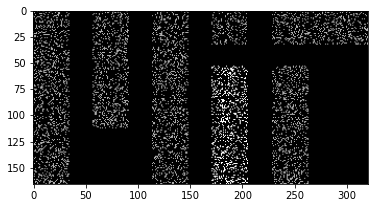

In [94]:
#image sau khi lấy nhiễu
X0= np.zeros((n1,n2))
for id in range(len( Omega)):
    i,j = Omega[id]
    X0[i,j] = b[id]
# X = matrix(X0)
plt.imshow(X0,cmap="gray")

In [95]:
rank = np.linalg.matrix_rank(X0)
rank

166

In [96]:
z=np.random.rand ( (n1*n2))


In [97]:
z

array([0.25457886, 0.51952386, 0.16165488, ..., 0.05120581, 0.62802895,
       0.12515726])

In [98]:
beta =1
mu = 1

In [99]:
def vec_to_mat_X(X):
    return np.reshape(X, (n1, n2))
# def vec_to_mat_X(X):
    # return np.reshape(X, (n1, n2))
# vec_to_mat_X(X).flatten()-X



In [100]:
A_TA

<53286x53286 sparse matrix of type '<class 'numpy.intc'>'
	with 10657 stored elements in Compressed Sparse Column format>

$\nabla f_2(X)  = A^T*A*X - A^T*b$

In [101]:

def nablaf_2(z):
    return A_TA@z- A_Tb
def compute_y_n( z, beta):
    return z-(1/beta)*nablaf_2(z)
nablaf_2(z)

array([  0.        , -95.48047614,   0.        , ...,   0.        ,
         0.62802895,   0.        ])

Ta can giải bài toán $min   \frac{1}{2}|AX-b|^2_2 +u*|X|_*$

where $A\in Mat_{p, n1*n2}$, and $X\in R^{n1*n2}$

*step 1: $y_n = z_n - \beta*∇f_2(z_n)$

where 

$z_n =X$

$$Prox_{1/\beta f_1} (y) =  U.p(\lambda).V^T$$

where $$p(\lambda) =  pos(\lambda-\beta)$$

$$\tau = \mu /  \beta$$

In [102]:

def proximal_nuclear(Y, beta, mu):
    tau = (mu/beta)
    U,Sigma,V = linalg.svd(np.reshape(Y, (n1, n2)))
    full_sigma  = np.zeros( (n1,n2), np.float_)
    for i in range(len(Sigma)):
        if Sigma[i]>tau:
            full_sigma[i][i] = Sigma[i]-tau
    return (U@full_sigma)@V
# proximal_nuclear(yticks, beta, mu )

In [103]:
def compute_x(z, mu=1, beta=1):
    y = compute_y_n( z, beta=1)
    return proximal_nuclear(y , beta, mu).flatten()


In [104]:
compute_x(z)

array([3.10879728e-01, 9.58993902e+01, 1.90765634e-01, ...,
       4.14263508e-02, 1.52927604e-02, 1.33368230e-01])

In [105]:
def main_loop(z, beta=1, mu=1, loop_size=1000 ):
    t=np.zeros( (loop_size), np.float_)
    t[0]=1
    Z=z
    Xold = compute_x(Z)
    # print(Xold.shape)
    # z=np.zeros( (loop_size), np.float_)
    frobenius_norm_ratio_old = 1
    count=0
    for n in range(loop_size-1):

        t[n+1]= (math.sqrt(4*t[n]*t[n]+1)+1)/2
        lambda_loop = 1+ (t[n]-1)/t[n+1]


        X = compute_x(Z)

        Z= Xold+ lambda_loop*(X-Xold)
        # print(Z)

        # print(Z)
        Xold = X

        # print(n, np.linalg.norm(vec_to_mat_X(Z)-M)/ np.linalg.norm(M))
        frobenius_norm_ratio = ( np.linalg.norm(vec_to_mat_X(Z)-M, "fro") / np.linalg.norm(M, "fro"))
        if frobenius_norm_ratio_old- frobenius_norm_ratio<0.00000001:
            count+=1
            frobenius_norm_ratio_old  = frobenius_norm_ratio

            if count>10:
            
            
                break
        else: 
            count=0
            frobenius_norm_ratio_old  = frobenius_norm_ratio
        # if frobenius_norm_ratio < 0.01:
        if n%10==0:
            print(n, frobenius_norm_ratio)
            # break
    return Z, frobenius_norm_ratio


In [106]:
X1=X0.flatten()
X1.shape

(53286,)

In [107]:
mu_0 = np.linalg.norm((A.T) * b)*(1e-4)

In [108]:
image_new, error = main_loop(X1, beta=1, mu=mu_0, loop_size=1000)


0 0.8927100853887779
10 0.8873622485997197
20 0.8766600717187242
30 0.8611281262656474
40 0.841282652656413
50 0.8175872305878783
60 0.7904172775167901
70 0.7600312585646354
80 0.7266610281015584
90 0.690524569045739
100 0.6517792279695972
110 0.6105817252446993
120 0.5671549612021018
130 0.521736431339777
140 0.47459478078402084
150 0.42604581008673836
160 0.3765088735116919
170 0.3265168529953075
180 0.27673176734322047
190 0.22808875612871587
200 0.1819810075511556
210 0.1404122428265696
220 0.1061711765808242
230 0.08214513512752382
240 0.0688565811562931
250 0.06212304540044951
260 0.056767430234471596
270 0.0515020509999383
280 0.04818888856961573
290 0.047758427396427654


Text(0.5, 1.0, '')

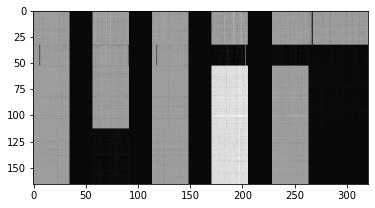

In [109]:
# plt.imshow(image_new.reshape(n1,n2),cmap="gray")
plt.imshow(image_new.reshape(n1,n2),cmap = "gray")
plt.title("")

Text(0.5, 1.0, 'Ảnh sau khi được phục hồi')

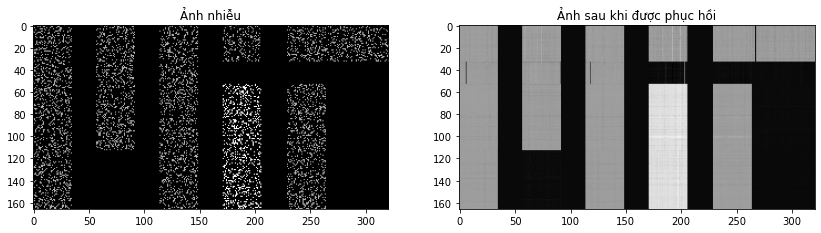

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
# fig.suptitle('Horizontally stacked subplots')
ax1.imshow(X0,cmap="gray")
ax1.set_title("Ảnh nhiễu")
ax2.imshow(image_new.reshape(n1,n2),cmap = "gray")
ax2.set_title("Ảnh sau khi được phục hồi")

In [111]:
M

array([[96, 96, 96, ..., 96, 96, 96],
       [96, 96, 96, ..., 96, 96, 96],
       [96, 96, 96, ..., 96, 96, 96],
       ...,
       [96, 96, 96, ...,  0,  0,  0],
       [96, 96, 96, ...,  0,  0,  0],
       [96, 96, 96, ...,  0,  0,  0]], dtype=uint8)

          $$ proximal_nuclear(X,beta,mu) =  prox_{\mu/beta}|| .||*  (X)$$